
# Assignment 1

Guillaume Thibault - 1948612

## Instructions:
* This is an individual assignment. You are not allowed to discuss the problems with other students.
* Part of this assignment will be autograded by gradescope. You can use it as immediate feedback to improve your answers.
* All your solution, code, analysis, graphs, explanations should be done in this same notebook.
* Please make sure to execute all the cells before you submit the notebook to the gradescope. You will not get points for the plots if they are not generated already.
* If you have questions regarding the assignment, you can ask for clarifications in Piazza. You should use the corresponding tag for this assignment.

This assignment has two questions. In question 1, you will learn:

1. To understand how to formalize a marketing campaign as a multi-arm bandit problem.
2. To implement $\epsilon$-greedy, UCB, and Boltzmann algorithms.
3. Understand the role of different hyper-parameters.

And in question 2 you will:

1. Implement and evaluate policy iteration and value iteration methods on FrozenLake environment.
2. Compare these methods on both deterministic and stochastic versions of the environment.

## Q1: Marketing Campaign (75 points)

Imagine you are running a marketing campaign for your website and have a set of ads to choose from. And say the objective is to show the ad with the highest click-through rate (CTR) value to drive the highest traffic possible. But you don't have any prior information about how either of these ads will perform. How do you approach this problem?

Definition: CTR is the ratio of how many times an ad was clicked vs. the number of impressions. For example, if an ad has been shown 100 times and clicked 10 times, CTR = 10/100 = 0.1

We will use the multi-armed bandit (MAB) method to solve this problem.

In this section, you should create a class for the marketing bandit, which contains a function pull that takes the chosen ad as the input and returns if the user has clicked on the ad or not. Each ad has a true CTR (a number between zero and one), which will be used to define a Bernoulli distribution. P(click) = true_CTR, P(no click) = 1 - true_CTR

In [1]:
import numpy as np
from random import choice
from scipy.stats import bernoulli
from typing import Sequence, Tuple
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(8953)
import warnings
warnings.filterwarnings('ignore')

### Q1.a: Define your Bandit class (5 points):

Most of the class has been written. Complete the pull method in such a way that: **1. Update both clicks and impressions, 2. Return if did_click is 0 or 1.**

In [24]:
class Bandit(object):

  def __init__(self, 
               n_arm: int = 2, 
               n_pulls: int = 2000,
               actual_ctr: list = [0.4, 0.6]
               ):
    self.n_arm = n_arm
    self.n_pulls = n_pulls
    self.init_bandit(actual_ctr=actual_ctr)
    self.clicks = {idx: 0 for idx in range(n_arm)} # number of times an ad is clicked on
    self.impressions = {idx: 0 for idx in range(n_arm)} # number of times an ad is chosen

  def init_bandit(self, 
                  actual_ctr: list = [0.4, 0.6],
                  ):
    """
    .inputs:
      actual_ctr: 
          Actual click through Rate.
    """
    self.actual_ctr = actual_ctr

  def pull(self, a_idx: int):
    """Requested in part (1.)
    .inputs:
      a_idx: Index of action.
    """
    assert a_idx < self.n_arm, "invalid action index"
    # ----------------------------------------------
    did_click = bernoulli.rvs(self.actual_ctr[a_idx])
    self.impressions[a_idx] += 1
    self.clicks[a_idx] += did_click
    # ----------------------------------------------
    return did_click

<!-- BEGIN QUESTION -->

#### Marketing campaign with three ads

Let's define a marketing campaign with three ads you need to choose from with actual CTR: {0.35, 0.55, 0.1}

In [25]:
#@title Problem definition
bandit = Bandit(n_arm=3, actual_ctr=[0.35, 0.55, 0.1])

### Q1.b1: Eps-greedy for k-armed bandit (5 points)

Implement the $\epsilon$-greedy method.

In [44]:
import random
def eps_greedy(
    bandit: Bandit, 
    eps: float, 
    ctr_init_val: float = .0
    ) -> Tuple[float, float, Sequence[float], Sequence[float]]:
  """
  .inputs: 
    bandit: A bandit problem, instantiated from the above class.
    eps: The epsilon value.
    ctr_init_val: Here we initialize all the table entries to the same value. 
  .outputs:
    rew_record: The record of rewards at each timestep.
    avg_ret_record: The average return up to step t, where t goes from 0 to n_pulls.
    tot_reg_record: The  regret up to step t, where t goes from 0 to n_pulls.
  """
  # init ctr (the estimates) (here we also keep a log of rewards)
  ctr = {idx: [ctr_init_val] for idx in range(bandit.n_arm)}
  ctr_estimated = [ctr_init_val]*bandit.n_arm

  # the total return 
  ret = .0
  rew_record = []
  avg_ret_record = []
  tot_reg_record = []

  opt_ctr = np.max(bandit.actual_ctr)

  for t in range(bandit.n_pulls):
    # ----------------------------------------------
    bandit_idx = -1
    
    if np.random.uniform() >= eps:
        # * Exploite the best one so far
        curr_opt_ctr = np.max(ctr_estimated)
        bandit_idx = ctr_estimated.index(curr_opt_ctr)
    else:
        # * Explore a random one
        random_bandit = choice(ctr_estimated)
        bandit_idx = ctr_estimated.index(random_bandit)

    # Display an ads and check if there's a click
    did_click = bandit.pull(bandit_idx)

    # Save the info
    rew_record.append(did_click)
    ret += did_click
    avg_ret_record.append(ret/(t+1))

    # Update the CTR estimate
    ctr_estimate = bandit.clicks[bandit_idx] / bandit.impressions[bandit_idx]
    ctr[bandit_idx].append(ctr_estimate)
    ctr_estimated[bandit_idx] = ctr_estimate

    curr_reg = (t+1) * opt_ctr - ret
    tot_reg_record.append(curr_reg)
    
    # ----------------------------------------------
  # calculate the regret
  reg = bandit.n_pulls * opt_ctr - ret


  return rew_record, avg_ret_record, tot_reg_record


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### Q1.b2: Plotting the results (5 points)

Use the driver code provided to plot:

(1) the averaged reward across the $N$=100 runs as a function of the number of pulls (2000 pulls for each run) for all three $eps$ values.

(2) the total regret, averaged across the $N$=100 runs as a function of the number of pulls for all three $eps$ values.

for three values of $eps$=0.2, 0.05, and 0

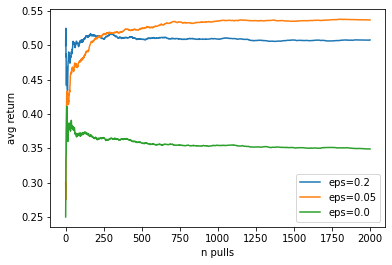

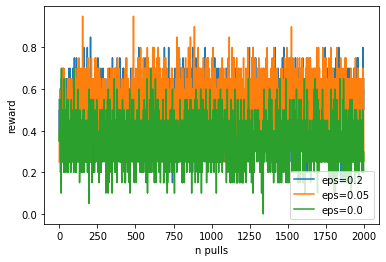

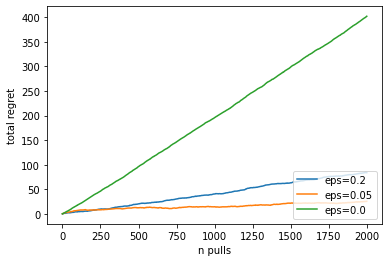

In [45]:
import time
plt.figure(0)
plt.xlabel("n pulls")
plt.ylabel("avg return")
plt.figure(1)
plt.xlabel("n pulls")
plt.ylabel("reward")
plt.figure(2)
plt.xlabel("n pulls")
plt.ylabel("total regret")

N = 20
tot_reg_rec_best = 1e8

for eps in [0.2, 0.05, .0]:
  rew_rec = np.zeros(bandit.n_pulls)
  avg_ret_rec = np.zeros(bandit.n_pulls)
  tot_reg_rec = np.zeros(bandit.n_pulls)
  start_time = time.time()
  for n in range(N):
    rew_rec_n, avg_ret_rec_n, tot_reg_rec_n = eps_greedy(bandit, eps)
    rew_rec += np.array(rew_rec_n)
    avg_ret_rec += np.array(avg_ret_rec_n)
    tot_reg_rec += np.array(tot_reg_rec_n)
  end_time = time.time()
  # print(f"time per run: {end_time - start_time}/N")
  # take the mean 
  rew_rec /= N
  avg_ret_rec /= N 
  tot_reg_rec /= N

  plt.figure(0)
  plt.plot(avg_ret_rec, label="eps={}".format(eps))
  plt.legend(loc="lower right")

  plt.figure(1)
  plt.plot(rew_rec[1:], label="eps={}".format(eps))
  plt.legend(loc="lower right")

  plt.figure(2)
  plt.plot(tot_reg_rec, label="eps={}".format(eps))
  plt.legend(loc="lower right")

  if tot_reg_rec[-1] < tot_reg_rec_best:
        ep_greedy_dict = {
            'reward':avg_ret_rec, 
            'regret_list':tot_reg_rec
        }
        tot_reg_rec_best = tot_reg_rec[-1]

#### Q1.b3: Analysis (5 points)


Explain the results from the perspective of exploration and how different $eps$ values affect the results.



For this implementation of the problem, we obtain that a very small epsilon, which is however not zero, is the best exploration rate. The agent with this epsilon can then find the best bandit relatively quickly and thus focus a large majority of future moves on the best bandit. 

Having an epsilon of zero is equivalent to taking a random bandit and keeping him without ever exploring. 

Having a large epsilon does not maximize the gain in this case because the distribution of bandits never changes so once you know who the best bandit is, it is not worth exploring further. However, having more exploration at the beginning will allow to have a better estimation of the different bandits more quickly and thus to have a bigger gain with not many tries. But this advantage is quickly lost because we continue to explore when a smaller epsilon has also found the best distribution

For this type of muti bandit problem, an initial exploration phase and then changing the epsilon to 0 would allow to have even more gain

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### Q1.b4: Optimistic Initial Value (5 points)
Run the optimistic initial value method on the same problem described above, for initial action-value estimates (1) Q1(a)=+0.6 for all a (2) Q1(a)=+100 for all a (Hint: You can use the same driver code). Compare its performance, measured by the average reward across $N$=100 runs as a function of the number of pulls, with the non-optimistic setting where Q1(a)=0 for all a. For both optimistic and non-optimistic settings, $eps$=0.

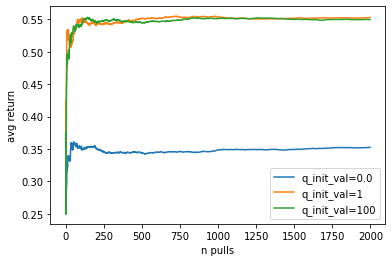

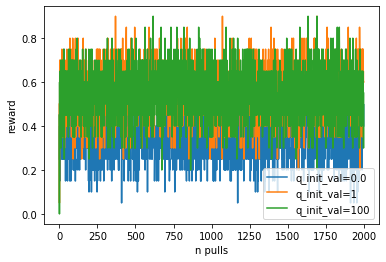

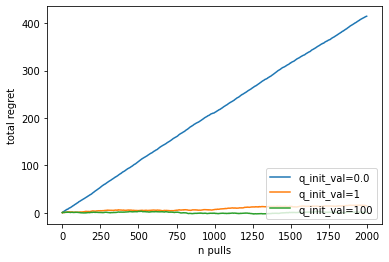

In [46]:
plt.figure(3)
plt.xlabel("n pulls")
plt.ylabel("avg return")

plt.figure(4)
plt.xlabel("n pulls")
plt.ylabel("reward")

plt.figure(5)
plt.xlabel("n pulls")
plt.ylabel("total regret")

N = 20
for ctr_init_val in [.0, 1, 100]:
  rew_rec = np.zeros(bandit.n_pulls)
  avg_ret_rec = np.zeros(bandit.n_pulls)
  for n in range(N):

    rew_rec_n, avg_ret_rec_n, tot_reg_rec_n = eps_greedy(bandit, eps=0, ctr_init_val=ctr_init_val)

    rew_rec += np.array(rew_rec_n)
    avg_ret_rec += np.array(avg_ret_rec_n)
    tot_reg_rec += np.array(tot_reg_rec_n)

  avg_ret_rec /= N
  rew_rec /= N
  tot_reg_rec /= N
  plt.figure(3)
  plt.plot(avg_ret_rec[1:], label="q_init_val={}".format(ctr_init_val))
  plt.legend(loc="lower right")

  plt.figure(4)
  plt.plot(rew_rec[1:], label="q_init_val={}".format(ctr_init_val))
  plt.legend(loc="lower right")

  plt.figure(5)
  plt.plot(tot_reg_rec[1:], label="q_init_val={}".format(ctr_init_val))
  plt.legend(loc="lower right")

#### Q1.b5: Analysis (5 points)

Explain how initial action-value estimates affect the exploration and the performance.

having an epsilon of 0, always choosing the bandit with the largest CTR estimate, and having a larger estimate of the CTR at the beginning allows to converge more quickly on the best distribution. This is because the agent will try the best distribution (all with a CTR of 1 and more!) and will lower the value of this one if it fails. 

This variant of the experiment shows that having a lot of exploration at the beginning and then choosing the distribution with the best CTR estimate has a high chance of maximizing the reward, taking into account that it does not change over time. 

<!-- END QUESTION -->

### Q1.c1: Upper-Confidence-Bound action selection (5 points)
Implement the UCB algorithm on the same MAB problem as above.

In [ ]:
def ucb(
    bandit: Bandit, 
    c: float, 
    ctr_init_val: float = .0
    ) -> Tuple[float, float, Sequence[float], Sequence[float]]:
  """
  .inputs: 
    bandit: A bandit problem, instantiated from the above class.
    c: The additional term coefficient.
    ctr_init_val: Note the difference between the optimal ctr and ctr. Here we
      initialize all the table entries to the same value. 
  .outputs:
    rew_record: The record of rewards at each timestep.
    avg_ret_record: The average return up to step t, where t goes from 0 to n_pulls.
    tot_reg_record: The  regret up to step t, where t goes from 0 to n_pulls.
  """
  # init ctr (the estimates) (here we also keep a log of rewards)
  ctr = {idx: [ctr_init_val] for idx in range(bandit.n_arm)}
  ucb_score = {idx: [0] for idx in range(bandit.n_arm)}

  # the total return 
  ret = .0
  rew_record = []
  avg_ret_record = []
  tot_reg_record = []

  # the optimal action is the one with max ctr
  opt_ctr = np.max(bandit.actual_ctr)

  # for numerical stability purposes
  eps = 1e-6

  for t in range(bandit.n_pulls):
    # Assuming to take the first arm always when there is no exploration
    # ----------------------------------------------
    ...
    # ----------------------------------------------
    
  # calculate the regret
  reg = bandit.n_pulls * opt_ctr - ret

  return rew_record, avg_ret_record, tot_reg_record

#### Q1.c2: Plotting the results (5 points)

Use the driver code provided to plot:

(1) the averaged reward across the $N$=100 runs as a function of the number of pulls (2000 pulls for each run) for all three $eps$ values.

(2) the total regret, averaged across the $N$=100 runs as a function of the number of pulls for all three $eps$ values.

for three values of $c$=0.2, 1.0, and 5.0.

In [ ]:
plt.figure(6)
plt.xlabel("n pulls")
plt.ylabel("avg return")
plt.figure(7)
plt.xlabel("n pulls")
plt.ylabel("reward")
plt.figure(8)
plt.xlabel("n pulls")
plt.ylabel("total regret")

N = 20
tot_reg_rec_best = 1e8
for c in [.2, 1.0, 5.0]:
  rew_rec = np.zeros(bandit.n_pulls)
  avg_ret_rec = np.zeros(bandit.n_pulls)
  tot_reg_rec = np.zeros(bandit.n_pulls)
  for n in range(N):
    rew_rec_n, avg_ret_rec_n, tot_reg_rec_n = ucb(bandit, c)
    rew_rec += np.array(rew_rec_n)
    avg_ret_rec += np.array(avg_ret_rec_n)
    tot_reg_rec += np.array(tot_reg_rec_n)

  # take the mean 
  rew_rec /= N 
  avg_ret_rec /= N 
  tot_reg_rec /= N

  plt.figure(6)
  plt.plot(avg_ret_rec, label="c={}".format(c))
  plt.legend(loc="lower right")

  plt.figure(7)
  plt.plot(rew_rec, label="c={}".format(c))
  plt.legend(loc="lower right")

  plt.figure(8)
  plt.plot(tot_reg_rec, label="c={}".format(c))
  plt.legend(loc="lower right")

  if tot_reg_rec[-1] < tot_reg_rec_best:
        ucb_dict = {
        'reward':avg_ret_rec, 
        'regret_list':tot_reg_rec,}
        tot_reg_rec_best = tot_reg_rec[-1]

#### Q1.c3: Analysis (5 points)


 Explain the results from the perspective of exploration and how different $c$ values affect the results.

Type your answer here

<!-- BEGIN QUESTION -->

### Q1.d1: Boltzmann policy (5 points)

Implement a Boltzmann policy that gets an array and temprature value ($tau$) and returns an index sampled from the Boltzmann policy.

In [ ]:
def boltzmann_policy(x, tau):
    """ Returns softmax probabilities with temperature tau
        Input:  x -- 1-dimensional array
        Output: idx -- chosen index
    """
    # ----------------------------------------------
    ...
    # ----------------------------------------------
    return idx

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q1.d2: Boltzmann algorithm (5 points)

Evaluate the Boltzmann algorithm on the same MAB problem as above, for three values of the parameters $tau$: $0.01$, $0.1$, and $1$. Use the driver code provided to plot their performances as measured by the average reward across $N$=100 runs as a function of the number of pulls.

In [ ]:
def boltzmann(
    bandit: Bandit,
    tau: float = 0.1,
    ctr_init_val: float = .0
    ) -> Tuple[float, float, Sequence[float], Sequence[float]]:
  """
  .inputs: 
    bandit: A bandit problem, instantiated from the above class.
    c: The additional term coefficient.
    ctr_init_val: Note the difference between the q_star and q. Here we
      initialize all the table entries to the same value. 
  .outputs:
    rew_record: The record of rewards at each timestep.
    avg_ret_record: The average return up to step t, where t goes from 0 to n_pulls.
    tot_reg_record: The  regret up to step t, where t goes from 0 to n_pulls.
  """
  # init q (the estimates) (here we also keep a log of rewards)
  ctr = {idx: [ctr_init_val] for idx in range(bandit.n_arm)}
  ctr_estimated = [ctr_init_val]*bandit.n_arm

  # the total return 
  ret = .0
  rew_record = []
  avg_ret_record = []
  tot_reg_record = []

  # equal q_star variance --> the optimal action is the one with max q_star_mean
  opt_ctr = np.max(bandit.actual_ctr)

  for t in range(bandit.n_pulls):
    # ----------------------------------------------
    ...
    # ----------------------------------------------
  # calculate the regret
  reg = bandit.n_pulls * opt_ctr - ret

  return rew_record, avg_ret_record, tot_reg_record

#### Q1.d3: Plotting the results (5 points)

In [ ]:
plt.figure(9)
plt.xlabel("n pulls")
plt.ylabel("avg return")
plt.figure(10)
plt.xlabel("n pulls")
plt.ylabel("reward")
plt.figure(11)
plt.xlabel("n pulls")
plt.ylabel("total regret")

N = 20
tot_reg_rec_best = 1e8
for tau in [0.01, 0.1, 1]:
  rew_rec = np.zeros(bandit.n_pulls)
  avg_ret_rec = np.zeros(bandit.n_pulls)
  tot_reg_rec = np.zeros(bandit.n_pulls)
  for n in range(N):
    rew_rec_n, avg_ret_rec_n, tot_reg_rec_n = boltzmann(bandit, tau=tau)
    rew_rec += np.array(rew_rec_n)
    avg_ret_rec += np.array(avg_ret_rec_n)
    tot_reg_rec += np.array(tot_reg_rec_n)

  # take the mean 
  rew_rec /= N 
  avg_ret_rec /= N 
  tot_reg_rec /= N

  plt.figure(9)
  plt.plot(avg_ret_rec, label="tau={}".format(tau))
  plt.legend(loc="lower right")

  plt.figure(10)
  plt.plot(rew_rec, label="tau={}".format(tau))
  plt.legend(loc="lower right")

  plt.figure(11)
  plt.plot(tot_reg_rec, label="tau={}".format(tau))
  plt.legend(loc="lower right")

  if tot_reg_rec[-1] < tot_reg_rec_best:
        boltzmann_dict = {
        'reward':avg_ret_rec, 
        'regret_list':tot_reg_rec,}
        tot_reg_rec_best = tot_reg_rec[-1]

#### Q1.d4: Analysis (5 points)

 Explain the role of $tau$ paramtere on the results.

Type your answer here

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q1.f1: Final comaprison (5 points)
Compare the performance of $\epsilon$-greedy, UCB and Boltzmann algorithms in single plot  as measured by the average reward and total regret across $N$=100 runs as a function of the number of pulls.

In [ ]:
plt.figure(12)
plt.plot(ep_greedy_dict["reward"], label="e-greedy")
plt.legend(loc="lower right")
plt.plot(ucb_dict["reward"], label="UCB")
plt.legend(loc="lower right")
plt.plot(boltzmann_dict["reward"], label="Boltzmann")
plt.legend(loc="lower right")
plt.xlabel("n pulls")
plt.ylabel("avg return")

plt.figure(13)
plt.plot(ep_greedy_dict["regret_list"], label="e-greedy")
plt.legend(loc="lower right")
plt.plot(ucb_dict["regret_list"], label="UCB")
plt.legend(loc="lower right")
plt.plot(boltzmann_dict["regret_list"], label="Boltzmann")
plt.legend(loc="lower right")
plt.xlabel("n pulls")
plt.ylabel("total regret")

#### Q1.f2: Analysis (5 points)

Comapre all the algorithms in terms of the performance.

Type your answer here

In [ ]:
plt.close('all')

<!-- END QUESTION -->

## Q2: Dynamic Programming (60 points)

Now you will implement value iteration and policy iteration for the Frozen Lake environment and evaluate them on both its deterministic and stochastic versions.

Consider a variation of the FrozenLake-v0 environment from the OpenAI gym library. The agent controls the movement of a character in a grid world. Some tiles of the frozen and walkable (F), while others are holes in the lake (H) that lead to the agent falling into the water. The states are denoted as: S = {0, 1, 2, . . . , 14, 15} for a 4x4 lake. The agent starts on a starting tile $(S)$, and its goal is to find the fastest
walkable path to a goal tile $(G)$. The agent can move in the four cardinal directions, $A$ = {left, down, right, up}, but the floor is slippery! Given a slip rate of 0 ≤ $\epsilon$ < 1, the agent will go in a random wrong direction with probability $\epsilon$. The reward is −1 on all transitions, except for three cases that all result in the episode terminating:
(1) The agent falling into a hole nets the agent a reward of −100,
(2) The agent takes over 100 steps, all the ice melts and the agent gets a reward of −200, and
(3) The agent reaches the goal state, rewarding it a reward of 0. The discount factor for this environment
should be set to γ = 0.99. The environment is implemented for you:

In [ ]:
#@title FrozenLake
import sys
from contextlib import closing

import numpy as np
from io import StringIO

from gym import utils

from gym import Env, spaces
from gym.utils import seeding
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
discount=0.99

MAPS = {
    "2x2": ["SF", "HG"],
    "4x4-easy":["SFFF", "FHFF", "FFFF", "HFFG"],
    "4x4": ["SFFF", "FHFH", "FFFH", "HFFG"],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG",
    ],
}



def categorical_sample(prob_n, np_random):
    """
    Sample from categorical distribution
    Each row specifies class probabilities
    """
    prob_n = np.asarray(prob_n)
    csprob_n = np.cumsum(prob_n)
    return (csprob_n > np_random.rand()).argmax()


class DiscreteEnv(Env):

    """
    Has the following members
    - nS: number of states
    - nA: number of actions
    - P: transitions (*)
    - isd: initial state distribution (**)
    (*) dictionary of lists, where
      P[s][a] == [(probability, nextstate, reward, done), ...]
    (**) list or array of length nS
    """

    def __init__(self, nS, nA, P, isd, max_length=100):
        self.P = P
        self.isd = isd
        self.lastaction = None  # for rendering
        self.nS = nS
        self.nA = nA

        self.action_space = spaces.Discrete(self.nA)
        self.observation_space = spaces.Discrete(self.nS)

        self.seed()
        self.s = categorical_sample(self.isd, self.np_random)
        self.max_length = max_length

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self):
        self.s = categorical_sample(self.isd, self.np_random)
        self.lastaction = None
        self.t = 0
        return int(self.s)

    def step(self, a):
        transitions = self.P[self.s][a]
        i = categorical_sample([t[0] for t in transitions], self.np_random)
        p, s, r, d = transitions[i]
        self.s = s
        self.lastaction = a
        if self.t >= self.max_length:
            d = True
            r = -200
        self.t += 1
        return (int(s), r, d, {"prob": p})

def generate_random_map(size=8, p=0.8):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0, 0))
        while frontier:
            r, c = frontier.pop()
            if not (r, c) in discovered:
                discovered.add((r, c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == "G":
                        return True
                    if res[r_new][c_new] != "H":
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(["F", "H"], (size, size), p=[p, 1 - p])
        res[0][0] = "S"
        res[-1][-1] = "G"
        valid = is_valid(res)
    return ["".join(x) for x in res]


class FrozenLakeEnv(DiscreteEnv):
    """
    Winter is here. You and your friends were tossing around a frisbee at the
    park when you made a wild throw that left the frisbee out in the middle of
    the lake. The water is mostly frozen, but there are a few holes where the
    ice has melted. If you step into one of those holes, you'll fall into the
    freezing water. At this time, there's an international frisbee shortage, so
    it's absolutely imperative that you navigate across the lake and retrieve
    the disc. However, the ice is slippery, so you won't always move in the
    direction you intend.
    The surface is described using a grid like the following
        SFFF
        FHFH
        FFFH
        HFFG
    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located
    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.
    """

    metadata = {"render.modes": ["human", "ansi"]}

    def __init__(self, desc=None, map_name="4x4", slip_rate=0.5):
        if desc is None and map_name is None:
            desc = generate_random_map()
        elif desc is None:
            desc = MAPS[map_name]
        self.desc = desc = np.asarray(desc, dtype="c")
        self.nrow, self.ncol = nrow, ncol = desc.shape
        self.reward_range = (0, 1)
        self.slip_rate=slip_rate

        nA = 4
        nS = nrow * ncol

        isd = np.array(desc == b"S").astype("float64").ravel()
        isd /= isd.sum()

        P = {s: {a: [] for a in range(nA)} for s in range(nS)}

        def to_s(row, col):
            return row * ncol + col

        def inc(row, col, a):
            if a == LEFT:
                col = max(col - 1, 0)
            elif a == DOWN:
                row = min(row + 1, nrow - 1)
            elif a == RIGHT:
                col = min(col + 1, ncol - 1)
            elif a == UP:
                row = max(row - 1, 0)
            return (row, col)

        def update_probability_matrix(row, col, action):
            newrow, newcol = inc(row, col, action)
            newstate = to_s(newrow, newcol)
            newletter = desc[newrow, newcol]
            done = bytes(newletter) in b"GH"
            # reward = float(newletter == b"G")
            reward = -1
            # if newletter == b"H":
            #     reward = -100
            done = False
            return newstate, reward, done

        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                for a in range(4):
                    li = P[s][a]
                    letter = desc[row, col]
                    if letter == b"G":
                        li.append((1, s, 0, True))
                    elif letter == b'H':
                        li.append((1, s, -100, True))
                    else:
                        if slip_rate > 0:
                            li.append((slip_rate/2.0, *update_probability_matrix(row, col, (a - 1) % 4)))
                            li.append((1 - slip_rate, *update_probability_matrix(row, col, a)))
                            li.append((slip_rate/2.0, *update_probability_matrix(row, col, (a + 1) % 4)))
                        else:
                            li.append((1, *update_probability_matrix(row, col, a)))

        super(FrozenLakeEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode="human"):
        outfile = StringIO() if mode == "ansi" else sys.stdout

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = self.desc.tolist()
        desc = [[c.decode("utf-8") for c in line] for line in desc]
        desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)
        if self.lastaction is not None:
            outfile.write(
                "  ({})\n".format(["Left", "Down", "Right", "Up"][self.lastaction])
            )
        else:
            outfile.write("\n")
        outfile.write("\n".join("".join(line) for line in desc) + "\n")

        if mode != "human":
            with closing(outfile):
                return outfile.getvalue()

#### Q2.a Generate an episode (5 points):
Complete the code below to generate an episode and return total rewards and number of steps during the episode.

In [ ]:
def generate_episode(policy, env, render=False):
    rewards = []
    done = False

    current_state = env.reset()
    steps = 0
    # ----------------------------------------------
    ...
    # ----------------------------------------------
    return episode_return, steps

#### Q2.b Tabular Policy iteration Implementation (15 points):
Implement policy_evaluation, policy_improvement and policy_iteration. policy_iteration runs the policy for 300 iterations while running  policy_evaluation and policy_improvement evey 5 episodes. Return the optimal value function and the optimal policy.

In [ ]:
#title
###########################################
##### ALL FUCTIONS FOR POLICY ITERATION ###
###########################################

def greedify_policy(Q_vals, tolerance=1e-9):
    '''
    chooses the optimal action at each step such that the agent moves to the state with the maximum value
    arguments:
        Q_vals - vector that stores the values of next states for each action
    return:
        greedy_policy - the greedified policy, a matrix containing prob of actions
    '''
    max_Q = np.max(Q_vals)
    greedy_policy = np.zeros(len(Q_vals))
    for action in range(len(Q_vals)):
        if np.abs(Q_vals[action]-max_Q)<=tolerance:
            greedy_policy[action] = 1.
    greedy_policy /= np.sum(greedy_policy)
    return greedy_policy


def policy_evaluation(environment, policy, theta=1e-8):
    '''
    Computes the value function for a given policy
    arguments:
        environment - class instance of an MDP environment
        policy - the policy for which value function is to be evaluated
        theta - tolerance level to decide convergence
    return:
        Value_fn - the estimated value of each state, evaluated for given policy
    '''
    Value_fn = np.zeros(environment.observation_space.n)
    # ----------------------------------------------
    ...
    # ----------------------------------------------
    return Value_fn

def policy_improvement(environment, Value_fn, curr_policy):
    '''
    Decides a new policy based on given value function
    arguments:
        environment - class instance of an MDP environment
        Value_fn - estimated value of each state
        curr_policy - present policy
    return:
        curr_policy - updated policy
        policy_stable - True/False flag indicating if policy was changed
    '''
    # ----------------------------------------------
    ...
    # ----------------------------------------------
    return curr_policy, policy_stable


def policy_iteration_with_performance(environment, theta=1e-8, iterations=90, train_steps=1, test_steps=5):
    '''
    Runs the tabular policy iteration algorithm for given iterations and returns cumulative reward and total steps at each iteration
    arguments:
        environment - class instance of an MDP environment
        theta - tolerance level to decide convergence
        iterations - number of iterations to run the algorithm
        train_steps - number of consecutive iterations to update the value function and policy
        test_steps - number of consecutive iterations to evaluate the current policy in the environment
    return:
        cumulative_reward_array - array of cumulative reward at each step (both train and test included)
        total_steps_array - array of total number of steps at each step (both train and test included)
    '''
    n_steps = train_steps+test_steps
    V = np.zeros(environment.nS)
    pi = np.random.rand(environment.nS,environment.nA)
    pi = pi/pi.sum(axis=1,keepdims=True)
    cumulative_reward_array = np.zeros(iterations)
    total_steps_array = np.zeros(iterations)
    for iter in range(iterations):
        cumulative_reward_array[iter], total_steps_array[iter] = generate_episode(pi, environment)
        if (iter%n_steps)>=test_steps:
            # ----------------------------------------------
            ...
            # ----------------------------------------------

    return cumulative_reward_array, total_steps_array, V, pi

def plot_performance_policy_iteration(env, iterations=90, train_steps=1, test_steps=5, num_seeds=5):
    '''
    Plots the performance metrics of tabular policy iteration algorithm
    arguments:
        env - MDP environment
        iterations - number of iterations to run the algorithm
        train_steps - number of consecutive iterations to update the value function and policy
        test_steps - number of consecutive iterations to evaluate the current policy in the environment
    return:
        
    '''
    cumulative_reward_array_train_plot = []
    cumulative_reward_array_test_plot = []
    total_steps_array_train_plot = []
    total_steps_array_test_plot = []
    for seed in range(num_seeds):
        np.random.seed(seed)
        env.seed(seed)
        cumulative_reward_array, total_steps_array, V, pi = policy_iteration_with_performance(env,theta=1e-3,iterations=iterations,train_steps=train_steps,test_steps=test_steps)
        all_idx = np.array(list(range(iterations)))
        train_idx = np.array([i for i in range(iterations) if i%(train_steps+test_steps)>=test_steps])
        test_idx = np.setdiff1d(all_idx,train_idx)
        cumulative_reward_array_train = cumulative_reward_array[train_idx]
        cumulative_reward_array_test = cumulative_reward_array[test_idx].reshape(-1,test_steps).mean(axis=1)
        total_steps_array_train = total_steps_array[train_idx]
        total_steps_array_test = total_steps_array[test_idx].reshape(-1,test_steps).mean(axis=1)
        cumulative_reward_array_train_plot.append(cumulative_reward_array_train)
        cumulative_reward_array_test_plot.append(cumulative_reward_array_test)
        total_steps_array_train_plot.append(total_steps_array_train)
        total_steps_array_test_plot.append(total_steps_array_test)
        
    cumulative_reward_array_train_plot = np.array(cumulative_reward_array_train_plot)
    cumulative_reward_array_test_plot = np.array(cumulative_reward_array_test_plot)
    cumulative_reward_array_train_mean = np.mean(cumulative_reward_array_train_plot,axis=0)
    cumulative_reward_array_train_std = np.std(cumulative_reward_array_train_plot,axis=0)
    cumulative_reward_array_test_mean = np.mean(cumulative_reward_array_test_plot,axis=0)
    cumulative_reward_array_test_std = np.std(cumulative_reward_array_test_plot,axis=0)
    total_steps_array_train_plot = np.array(total_steps_array_train_plot)
    total_steps_array_test_plot = np.array(total_steps_array_test_plot)
    total_steps_array_train_mean = np.mean(total_steps_array_train_plot,axis=0)
    total_steps_array_train_std = np.std(total_steps_array_train_plot,axis=0)
    total_steps_array_test_mean = np.mean(total_steps_array_test_plot,axis=0)
    total_steps_array_test_std = np.std(total_steps_array_test_plot,axis=0)
    
    plt.figure(14);
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.plot(np.linspace(1,len(cumulative_reward_array_test_mean),len(cumulative_reward_array_test_mean)),cumulative_reward_array_test_mean,label='Mean cumulative reward of an episode')
    plt.fill_between(np.linspace(1,len(cumulative_reward_array_test_mean),len(cumulative_reward_array_test_mean)),cumulative_reward_array_test_mean-cumulative_reward_array_test_std,cumulative_reward_array_test_mean+cumulative_reward_array_test_std,alpha=0.4)
    optimal_reward_test = np.max(cumulative_reward_array_test_plot,axis=1)
    plt.axhline(y=np.mean(optimal_reward_test),color='k',linestyle='--',label='Optimal performance')
    plt.axhspan(np.mean(optimal_reward_test)-np.std(optimal_reward_test),np.mean(optimal_reward_test)+np.std(optimal_reward_test),alpha=0.2,color='k')
    plt.title('Cumulative Reward during testing vs episodes with Policy iteration',size=12)
    plt.ylabel('Cumulative reward',size=12)
    plt.xlabel('Episodes',size=12)
#     plt.xscale('log')
    plt.legend()
    
    plt.figure(15);
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.plot(np.linspace(1,len(total_steps_array_test_mean),len(total_steps_array_test_mean)),total_steps_array_test_mean,label='Mean steps of an episode')
    plt.fill_between(np.linspace(1,len(total_steps_array_test_mean),len(total_steps_array_test_mean)),total_steps_array_test_mean-total_steps_array_test_std,total_steps_array_test_mean+total_steps_array_test_std,alpha=0.4)
    optimal_steps_test = np.min(total_steps_array_test_plot,axis=1)
    plt.axhline(y=np.mean(optimal_steps_test),color='k',linestyle='--',label='Optimal performance')
    plt.axhspan(np.mean(optimal_steps_test)-np.std(optimal_steps_test),np.mean(optimal_steps_test)+np.std(optimal_steps_test),alpha=0.2,color='k')
    plt.title('Total steps per episode during testing vs episodes with Policy iteration',size=12)
    plt.ylabel('Total steps/episode',size=12)
    plt.xlabel('Episodes',size=12)
#     plt.xscale('log')
    plt.legend()
    # plt.show()

#### Q2.c: Tabular Value Iteration Implementation (10 points)
Implement value_iteration algorithm and evaluate it for 300 iterations while performing value iteration updates every 5 iteration. Return the optimal value function and the optimal policy.

In [ ]:
#@title
###########################################
##### ALL FUCTIONS FOR VALUE ITERATION ###
###########################################

def value_iteration_with_performance(environment, theta=1e-8, iterations=90, train_steps=1, test_steps=5):
    '''
    Runs the tabular value iteration algorithm for given iterations and returns cumulative reward and total steps at each iteration
    arguments:
        environment - class instance of an MDP environment
        theta - tolerance level to decide convergence
        iterations - number of iterations to run the algorithm
        train_steps - number of consecutive iterations to update the value function and policy
        test_steps - number of consecutive iterations to evaluate the current policy in the environment
    return:
        cumulative_reward_array - array of cumulative reward at each step (both train and test included)
        total_steps_array - array of total number of steps at each step (both train and test included)
    '''
    n_steps = train_steps+test_steps
    V = np.zeros(environment.nS)
    pi = np.random.rand(environment.nS,environment.nA)
    pi = pi/pi.sum(axis=1,keepdims=True)
    cumulative_reward_array = np.zeros(iterations)
    total_steps_array = np.zeros(iterations)
    for iter in range(iterations):
        cumulative_reward_array[iter], total_steps_array[iter] = generate_episode(pi, environment)
        if (iter%n_steps)>=test_steps:
            # ----------------------------------------------
            ...
            # ----------------------------------------------

    return cumulative_reward_array, total_steps_array, V, pi

def plot_performance_value_iteration(env, iterations=90, train_steps=1, test_steps=5, num_seeds=5):
    '''
    Plots the performance metrics of tabular value iteration algorithm
    arguments:
        env_class - MDP environment class
        iterations - number of iterations to run the algorithm
        train_steps - number of consecutive iterations to update the value function and policy
        test_steps - number of consecutive iterations to evaluate the current policy in the environment
    return:
        
    '''
    cumulative_reward_array_train_plot = []
    cumulative_reward_array_test_plot = []
    total_steps_array_train_plot = []
    total_steps_array_test_plot = []
    for seed in range(num_seeds):
        np.random.seed(seed)
        env.seed(seed)
        cumulative_reward_array, total_steps_array, V, pi = value_iteration_with_performance(env,theta=1e-3, iterations=iterations)
        all_idx = np.array(list(range(iterations)))
        train_idx = np.array([i for i in range(iterations) if i%(train_steps+test_steps)>=test_steps])
        test_idx = np.setdiff1d(all_idx,train_idx)
        cumulative_reward_array_train = cumulative_reward_array[train_idx]
        cumulative_reward_array_test = cumulative_reward_array[test_idx].reshape(-1,test_steps).mean(axis=1)
        total_steps_array_train = total_steps_array[train_idx]
        total_steps_array_test = total_steps_array[test_idx].reshape(-1,test_steps).mean(axis=1)
        cumulative_reward_array_train_plot.append(cumulative_reward_array_train)
        cumulative_reward_array_test_plot.append(cumulative_reward_array_test)
        total_steps_array_train_plot.append(total_steps_array_train)
        total_steps_array_test_plot.append(total_steps_array_test)
    cumulative_reward_array_train_plot = np.array(cumulative_reward_array_train_plot)
    cumulative_reward_array_test_plot = np.array(cumulative_reward_array_test_plot)
    cumulative_reward_array_train_mean = np.mean(cumulative_reward_array_train_plot,axis=0)
    cumulative_reward_array_train_std = np.std(cumulative_reward_array_train_plot,axis=0)
    cumulative_reward_array_test_mean = np.mean(cumulative_reward_array_test_plot,axis=0)
    cumulative_reward_array_test_std = np.std(cumulative_reward_array_test_plot,axis=0)
    total_steps_array_train_plot = np.array(total_steps_array_train_plot)
    total_steps_array_test_plot = np.array(total_steps_array_test_plot)
    total_steps_array_train_mean = np.mean(total_steps_array_train_plot,axis=0)
    total_steps_array_train_std = np.std(total_steps_array_train_plot,axis=0)
    total_steps_array_test_mean = np.mean(total_steps_array_test_plot,axis=0)
    total_steps_array_test_std = np.std(total_steps_array_test_plot,axis=0)
    plt.figure(16);
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.plot(np.linspace(1,len(cumulative_reward_array_test_mean),len(cumulative_reward_array_test_mean)),cumulative_reward_array_test_mean,label='Mean cumulative reward of an episode')
    plt.fill_between(np.linspace(1,len(cumulative_reward_array_test_mean),len(cumulative_reward_array_test_mean)),cumulative_reward_array_test_mean-cumulative_reward_array_test_std,cumulative_reward_array_test_mean+cumulative_reward_array_test_std,alpha=0.4)
    optimal_reward_test = np.max(cumulative_reward_array_test_plot,axis=1)
    plt.axhline(y=np.mean(optimal_reward_test),color='k',linestyle='--',label='Optimal performance')
    plt.axhspan(np.mean(optimal_reward_test)-np.std(optimal_reward_test),np.mean(optimal_reward_test)+np.std(optimal_reward_test),alpha=0.2,color='k')
    plt.title('Cumulative Reward during testing vs episodes with Value iteration',size=12)
    plt.ylabel('Cumulative reward',size=12)
    plt.xlabel('Episodes',size=12)
#     plt.xscale('log')
    plt.legend()
    plt.figure(17);
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.plot(np.linspace(1,len(total_steps_array_test_mean),len(total_steps_array_test_mean)),total_steps_array_test_mean,label='Mean steps of an episode')
    plt.fill_between(np.linspace(1,len(total_steps_array_test_mean),len(total_steps_array_test_mean)),total_steps_array_test_mean-total_steps_array_test_std,total_steps_array_test_mean+total_steps_array_test_std,alpha=0.4)
    optimal_steps_test = np.min(total_steps_array_test_plot,axis=1)
    plt.axhline(y=np.mean(optimal_steps_test),color='k',linestyle='--',label='Optimal performance')
    plt.axhspan(np.mean(optimal_steps_test)-np.std(optimal_steps_test),np.mean(optimal_steps_test)+np.std(optimal_steps_test),alpha=0.2,color='k')
    plt.title('Total steps per episode during testing vs episodes with Value iteration',size=12)
    plt.ylabel('Total steps/episode',size=12)
    plt.xlabel('Episodes',size=12)
#     plt.xscale('log')
    plt.legend()
    # plt.show()

<!-- BEGIN QUESTION -->

#### Q2.d1: PI and VI experiments (10 points)
Run both methods on the 4x4 FrozenLake environment with $\textit{slip_rate=0}$ for 5 independent seeds and plot the cumulative reward and total steps per episode for each method using *plot_performance_policy_iteration* and *plot_performance_value_iteration* functions.

In [ ]:
env=FrozenLakeEnv(map_name="4x4", slip_rate=0)
# PI
# ----------------------------------------------
...
# ----------------------------------------------

# VI
# ----------------------------------------------
...
# ----------------------------------------------

#### Q2.d2: PI and VI visualizations (5 points)
Visualize the value function for both methods using policy_iteration_with_performance and value_iteration_with_performance functions.

In [ ]:
...

In [ ]:
plt.imshow(V.reshape(int(np.sqrt(env.nS)),int(np.sqrt(env.nS))), vmin=-10); plt.colorbar(); # plt.show()

In [ ]:
...

In [ ]:
plt.imshow(V.reshape(int(np.sqrt(env.nS)),int(np.sqrt(env.nS))), vmin=-10); plt.colorbar(); # plt.show()

#### Q2.d3: Analysis (5 points)

What do you observe in these plots?

Type your answer here

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q2.e1: Stochastic FrozenLake (10 points)
Rerun the previous part using 4x4 FrozenLake environment but this time with $\textit{slip_rate=0.1}$.

In [ ]:
# Define the env=...
# ----------------------------------------------
...
# ----------------------------------------------

# PI
# ----------------------------------------------
...
# ----------------------------------------------

# VI
# ----------------------------------------------
...
# ----------------------------------------------

### Q2.e2: Analysis (5 points)

Type your answer here

In [ ]:
plt.close('all')